In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
import sys
sys.path.insert(1, '../tools')
from data_tools import *

In [6]:
bay_area_demo = pd.read_csv('../data/bay_area_demography.csv')
all_businesses_info = pd.read_csv('../data/all_businesses_info.csv')
all_reviews = pd.read_csv('../data/all_reviews.csv')

In [7]:
def check_unique_dtypes(in_arr):
    return np.unique([type(i).__name__ for i in in_arr]).tolist()

# Clean text

In [8]:
from nltk.tokenize import RegexpTokenizer
import re

In [9]:
def processed_text(in_str):
    lower_str = in_str.lower()
    splited_str = re.split(r'[.\s]', lower_str)
    return splited_str

In [10]:
def clean_text(in_str):
    """ clean an input str by
        1. lower it
        2. removed all punctuations and symbols
    """
    after_re = [re.sub(r'^[/\_\W]+|[\_\W]+$|\d|\n', '', i) for i in in_str]
    processed = [i for i in after_re if i != '']
    return processed

In [11]:
texts = [clean_text(processed_text(i)) for i in tqdm(all_reviews['text'])]
texts = [clean_text(i) for i in tqdm(texts)]
texts = [' '.join(i) for i in texts]

In [53]:
labels = all_reviews['rating'].values
binary_labels = [0 if i <= 3 else 1 for i in labels]

In [54]:
texts_labels = pd.DataFrame({'texts':texts, 'labels':labels, 'binary_labels':binary_labels})
texts_labels = texts_labels.sample(frac=1).reset_index(drop=True)

# Tokenize and numeric vector

In [55]:
from keras.preprocessing.text import Tokenizer

In [56]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts_labels.texts.values)

In [57]:
sequences = tokenizer.texts_to_sequences(texts_labels.texts.values)

In [58]:
texts_labels['sequence'] = sequences

In [59]:
texts_labels.head()

,texts,labels,binary_labels,sequence
0,i've been to pings many times all dinner visit...,4.0,1,"[46, 36, 5, 139, 96, 48, 111, 1694, 13, 298, 1..."
1,never fails i have been going to this establis...,5.0,1,"[105, 3390, 3, 26, 36, 186, 5, 8, 822, 9, 128,..."
2,sad day love their tacos but every time i orde...,2.0,0,"[986, 164, 58, 38, 84, 18, 166, 35, 3, 64, 4, ..."
3,i am very dissapointed with bbq pork moo yang ...,1.0,0,"[3, 125, 34, 5624, 19, 255, 291, 7026, 4814, 1..."
4,i've tried several kabob restaurants in the ba...,5.0,1,"[46, 108, 376, 658, 246, 10, 1, 149, 86, 116, ..."


__Output the cleaned text to .csv__

In [119]:
texts_labels['reviews_id'] = all_reviews.id

In [122]:
# texts_labels[['texts','labels','reviews_id']].to_csv('../data/cleaned_texts.csv', index=False)

# Train Test Split

In [60]:
from keras import preprocessing

In [63]:
train_ratio = 0.8
train_cutoff = round(texts_labels.shape[0]*train_ratio)

In [64]:
# splitted data as a dataframe
train_data = texts_labels.iloc[range(0,train_cutoff)]
test_data = texts_labels.iloc[range(train_cutoff, texts_labels.shape[0])]

__For binary output__

In [65]:
x_train = preprocessing.sequence.pad_sequences(train_data['sequence'], 25)
x_test = preprocessing.sequence.pad_sequences(test_data['sequence'], 25)

In [66]:
y_train = texts_labels['binary_labels'].values[:train_cutoff]
y_test = texts_labels['binary_labels'].values[train_cutoff:]

__For all classes output__

In [67]:
from keras.utils.np_utils import to_categorical

In [68]:
y_train_all = to_categorical(train_data['labels'])
y_test_all = to_categorical(test_data['labels'])

# Model - Binary Output

In [69]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [70]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [73]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 35908 samples, validate on 8978 samples
Epoch 1/10
35908/35908 [==============================] - 8s 229us/step - loss: 0.4878 - acc: 0.7638 - val_loss: 0.4343 - val_acc: 0.7967
Epoch 2/10
35908/35908 [==============================] - 8s 216us/step - loss: 0.3862 - acc: 0.8254 - val_loss: 0.4204 - val_acc: 0.8060
Epoch 3/10
35908/35908 [==============================] - 8s 224us/step - loss: 0.3600 - acc: 0.8411 - val_loss: 0.4103 - val_acc: 0.8134
Epoch 4/10
35908/35908 [==============================] - 8s 227us/step - loss: 0.3436 - acc: 0.8478 - val_loss: 0.4100 - val_acc: 0.8134
Epoch 5/10
35908/35908 [==============================] - 8s 229us/step - loss: 0.3292 - acc: 0.8544 - val_loss: 0.4110 - val_acc: 0.8108
Epoch 6/10
35908/35908 [==============================] - 8s 227us/step - loss: 0.3163 - acc: 0.8599 - val_loss: 0.4174 - val_acc: 0.8158
Epoch 7/10
35908/35908 [==============================] - 8s 229us/step - loss: 0.3026 - acc: 0.8668 - val_loss: 0.4125 - v

## Model Evaluation

### Validation vs Train

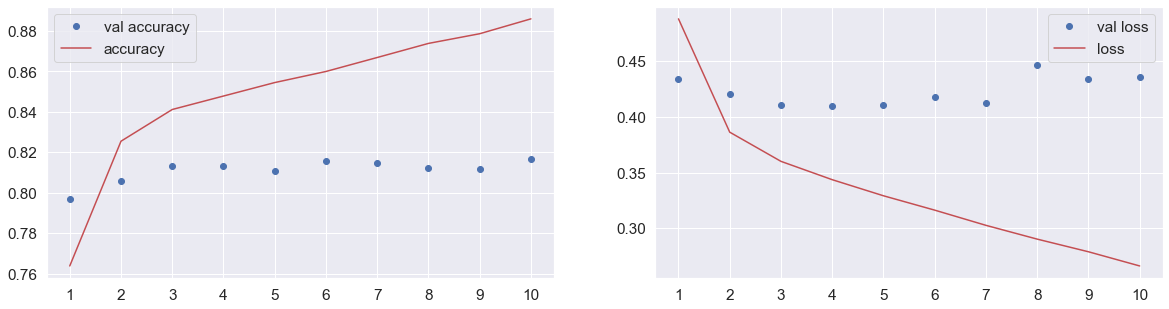

In [75]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(range(10), history.history['val_acc'], 'bo', label='val accuracy', color='b')
plt.plot(range(10), history.history['acc'], 'b', label='accuracy', color='r')
plt.xticks(range(0,10), range(1,21))
plt.legend()

plt.subplot(122)
plt.plot(range(10), history.history['val_loss'], 'bo', label='val loss', color='b')
plt.plot(range(10), history.history['loss'], 'b', label='loss', color='r')
plt.xticks(range(0,10), range(1,11))
plt.legend()
plt.show()

In [76]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss: {}\nTest accuracy: {}'.format(test_loss, test_acc))

11222/11222 [==============================] - 1s 109us/step
Test loss: 0.41348731223008484
Test accuracy: 0.8235608625488472


### Confusion Matrix & Precision and Recall

In [95]:
from sklearn.metrics import confusion_matrix, classification_report

In [78]:
import seaborn as sns

In [79]:
model_prediction = model.predict_classes(x_test)
model_prediction = [j for i in model_prediction for j in i]

In [80]:
con_matrix = confusion_matrix(y_test, model_prediction)

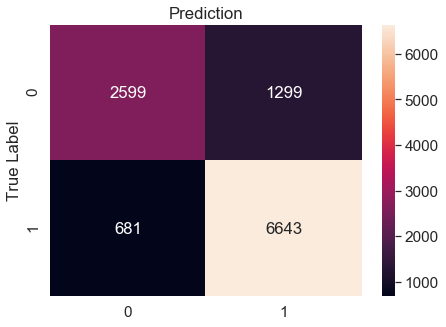

In [92]:
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4)
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.title('Prediction')
plt.show()

In [99]:
class_report = classification_report(y_test, model_prediction, target_names=['negative_reveiws', 'positive_reviews'])
print(class_report)

                  precision    recall  f1-score   support

negative_reveiws       0.79      0.67      0.72      3898
positive_reviews       0.84      0.91      0.87      7324

        accuracy                           0.82     11222
       macro avg       0.81      0.79      0.80     11222
    weighted avg       0.82      0.82      0.82     11222



### ROC AUC

In [108]:
from sklearn.metrics import roc_curve, auc

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test).ravel())

In [110]:
auc_ = auc(fpr, tpr)

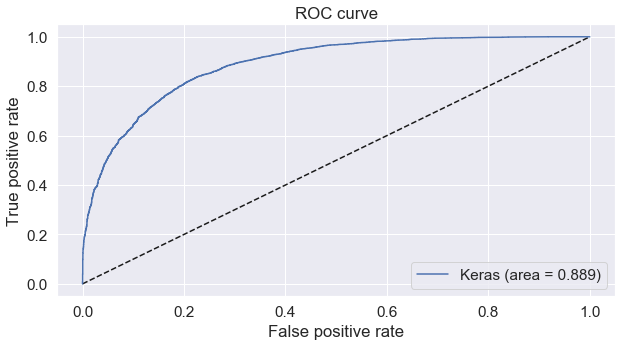

In [112]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Prediction

In [113]:
def custom_prediction(sentence):
    """ prediction with your own sentense
    """
    sentence_seq = tokenizer.texts_to_sequences(np.array([sentence]))
    seq_num = preprocessing.sequence.pad_sequences(sentence_seq, 20)
    label = model.predict_classes(seq_num)[0][0]
    return label

In [114]:
sentence = 'the wait is so long but their food is awesome'
custom_prediction(sentence)

1